In [ ]:
!pip install open3d

#Libraries and goodle drive

In [ ]:
import os, math, glob
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We are sampling 150000 uniformly distributed points. Considering that meshes were already normalised, 150k is a trade-off which accounts sufficiently for  density and details in the object representations.

We deploy 64 views. This parameter controls how many virtual cameras are used to look at the object from multiple perspectives upon performing surface extraction. 64 is a perfect alignment since it settles dense coverage every 5-6 degrees.

Voxel parameter sets the merging power: if several points fall into the same cube, they get merged into one representative point. Since the objects are normalised (radius 1), the full diameter becomes 2. 0.003 guarantees light smoothing and shape preservation, while removes dense clusters of cognate samples.

In [ ]:
CAR_PATHS = [
    "/content/drive/MyDrive/Coding-challenge/input/car_1/mesh.obj",
    "/content/drive/MyDrive/Coding-challenge/input/car_2/mesh.obj",
    "/content/drive/MyDrive/Coding-challenge/input/car_3/mesh.obj",
]

np.random.seed(42) # reproducibility
OUT_DIR = "processed" # folder for processed files
TARGET_POINTS = 150_000 # number of points in the final output cloud
INTERMEDIATE_POINTS = 200_000 # number of points used for resampling before smoothing/reconstruction part
VIEWS = 64
VOXEL = 0.003

In [ ]:
os.makedirs(OUT_DIR, exist_ok=True) # Directory

In [ ]:
def visualise(pcd, title="", max_points = 20000):
  points = np.asarray(pcd.points)
  if len(points) > max_points:
    indices = np.random.choice(len(points), max_points, replace=False)
    points = points[indices]

  figure = plt.figure(figsize=(5,5))
  ax = figure.add_subplot(111, projection='3d')
  ax.scatter(points[:,0], points[:,1], points[:,2], s=0.2)
  ax.set_axis_off()
  ax.set_box_aspect((1,1,1))
  plt.show()

`resampling` function performs point cloud resampling using a Poisson disk sampling followed by voxel downsampling and normal extimation.

In [ ]:
def resampling(mesh, n=INTERMEDIATE_POINTS, voxel=VOXEL):
  pcd = mesh.sample_points_poisson_disk(number_of_points=n, init_factor=5)
  if voxel and voxel > 0:
    pcd = pcd.voxel_down_sample(voxel_size=voxel)
  pcd.estimate_normals() # reset normal vectors since voxelisation changes point locations
  return pcd


# Fibonacci spiral

`fib_sphere` yields n evenly distributed points on the surface of a sphere.

I came down in favour of Fibonacci instead of uniform grid since if the points are sampled longitude and latitude evenly, points congregate around the poles. In contradistinction to this, Fibonacci method spreads out the points evenly across the sphere. As a result, we derive the grid of points with nearly equal-area spacing over the entire sphere.

In [ ]:
def fib_sphere(n):
  points = []
  phi = (1 + 5**0.5) / 2
  for i in range(n):
    z = 1 - 2*(i + 0.5) / n # height of the point on the sphere (along the vertical axis)
    r = (1 - z*z)**0.5 # radius of horizontal circle
    th = 2*math.pi*i / phi # longitude angle
    points.append([r*math.cos(th), r*math.sin(th), z]) # polar coordinates
  return np.array(points)

# Shell extraction

`extract_shell` function ejects only the exterior points of a 3D point cloud by replicating multiple virtual camera viewpoints.

The idea lies in creating a Boolean mask set to False by default and then turning to True the points clearly visible from any camera vista.

In [ ]:
def extract_shell(pcd, views=VIEWS, radius=2.5):
  to_save = np.zeros(len(pcd.points), dtype=bool)
  for i in fib_sphere(views):
    cam_persp = radius * i
    _, indices = pcd.hidden_point_removal(cam_persp, radius=radius*2.7) # we need a radius a bit larger than the camera distance
    # empirically it is known to be valid that multiplying by about 2.5-3 gives a stable result
    to_save[indices] = True
  new_pcd = pcd.select_by_index(np.where(to_save)[0])
  new_pcd, _ = new_pcd.remove_statistical_outlier(nb_neighbors=30, std_ratio=2.0) # delete noise and perturvbations + spurious points in general
  new_pcd.estimate_normals() # we renormalise estimates since the point cloud has changed, OLD NORMALS ARE NO LONGER VALID
  return new_pcd

# Poisson reconstruction

in `reconstruct_and_smooth` function i resolved to turn to good account poisson surface reconstruction approach. It turns a point cloud and given normals into a smooth and continuous triangle shell enveloping the contour.

Then, as evinced by the poisson reconstruction approach, it may often create an oversized envelope. Hence bounding-box alignment came into effect so as to have the contour cling to the real bounds of the object in the consideration.

Besides, duplicates, structure-depricating triangles also have got ruled out.

In [ ]:
def reconstruct_and_smooth (pcd):
  # poisson surface reconstruction
  mesh_rec, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10)
  mesh_rec = mesh_rec.crop(pcd.get_axis_aligned_bounding_box())
  mesh_rec = mesh_rec.remove_duplicated_triangles()
  mesh_rec = mesh_rec.remove_duplicated_vertices()
  mesh_rec = mesh_rec.remove_degenerate_triangles()
  mesh_rec = mesh_rec.remove_non_manifold_edges()

  # used to reduce noise. Unlike laplacian does,
  # Taubin smoothing averts shrinking the model
  mesh_smooth = mesh_rec.filter_smooth_taubin(number_of_iterations=10)
  return mesh_smooth

`final_pcd` function converts the smoothed and reconstructed mesh back into a clean and uniformly distributed point cloud.

Here i replace the points with new, evenly spaced points sampled from the clean and continuous surface that i reconstructed from the exterior points previously.


In [ ]:
def final_pcd(mesh, n=TARGET_POINTS, voxel=VOXEL):
  pcd = mesh.sample_points_poisson_disk(number_of_points=n, init_factor=5)
  if voxel and voxel > 0:
    pcd = pcd.voxel_down_sample(voxel_size=voxel)
  pcd.estimate_normals()
  return pcd

# Major Driver


=== Car object 1 ===
exterior: 35,052 points
final: 150,000 points


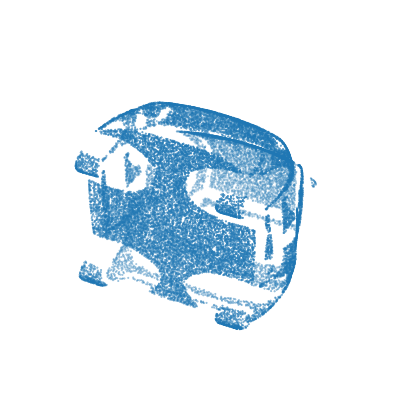

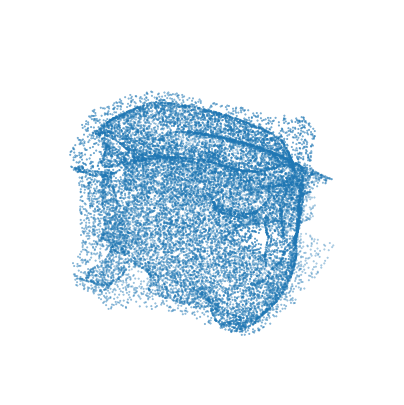


=== Car object 2 ===
exterior: 63,214 points
final: 150,000 points


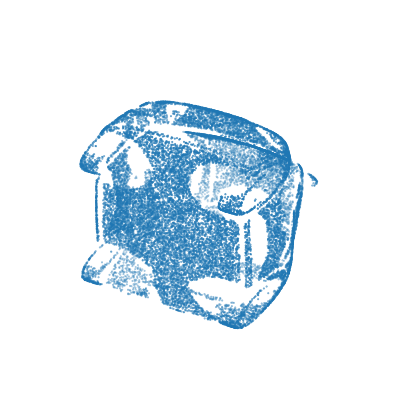

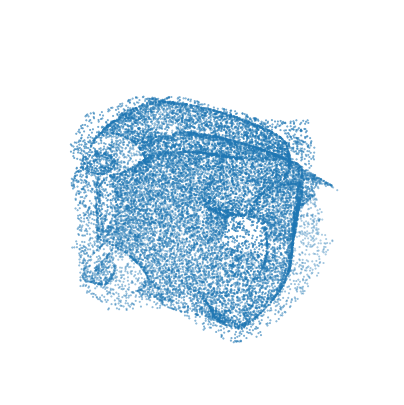


=== Car object 3 ===
exterior: 61,974 points
final: 150,000 points


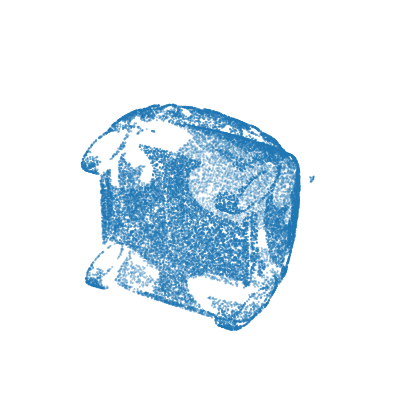

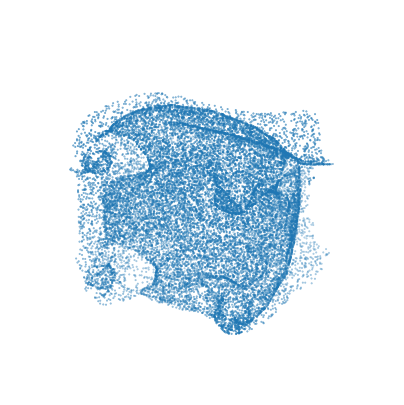


Processing has been completed. Files saved in: processed


In [15]:
for i, path in enumerate(CAR_PATHS, 1):
  print(f"\n=== Car object {i} ===")
  mesh = o3d.io.read_triangle_mesh(path)

  # Resample
  pcd_res = resampling(mesh)

  # Surface extraction
  pcd_ext = extract_shell(pcd_res, views=VIEWS)

  # Reconstruct and smooth a mesh
  mesh_rec_sm = reconstruct_and_smooth(pcd_ext)

  # Final smoothed surface points
  pcd_final = final_pcd(mesh_rec_sm, n=TARGET_POINTS)

  # save outputs
  o3d.io.write_point_cloud(f"{OUT_DIR}/car{i}_exterior.ply", pcd_ext)
  o3d.io.write_triangle_mesh(f"{OUT_DIR}/car{i}_surface_mesh_smooth.ply", mesh_rec_sm)
  o3d.io.write_point_cloud(f"{OUT_DIR}/car{i}_final.ply", pcd_final)

  print(f"exterior: {len(pcd_ext.points):,} points")
  print(f"final: {len(pcd_final.points):,} points")

  visualise(pcd_ext, title=f"Car {i} surface extraction")
  visualise (pcd_final, title=f"Car {i} smoothed and continuous contour")

print("\nProcessing has been completed. Files saved in:", OUT_DIR)